In [51]:
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import norm


In [45]:
# Function to reshape the matrix:
def gen_dissimilarity_matrix(data, size=[20, 20]):

    dissimilarity_matrix = np.zeros(size)
    ctr = 0
    for i in range(size[0]):
        for j in range(i+1, size[0]):
            if ctr >= data.shape[0]:
                break
            dissimilarity_matrix[i, j] = data[ctr]
            dissimilarity_matrix[j, i] = data[ctr]
            ctr += 1
    return dissimilarity_matrix


# Function to simulate ratings and calculate ICC
def simulate_icc(initial_raters, items=210, target_icc=0.7, inter_rater_noise=2, seed=123):
    np.random.seed(seed)  # For reproducibility
    
    # Generate simulated ratings
    # Create ground truth similarity:
    sim_ground_truth = np.random.normal(loc=10, scale=4, size=(items))
    # Create single subject data:
    ratings = np.zeros([items, initial_raters])
    for i in range(initial_raters):
        subject_noise = np.random.normal(loc=0, scale=inter_rater_noise, size=(items))
        ratings[:, i] = sim_ground_truth + subject_noise
    
    # Convert the numpy array to a DataFrame, which is needed for pingouin's ICC function
    import pandas as pd
    df = pd.DataFrame(ratings)
    
    # Reshape the DataFrame for pingouin ICC calculation: long format with 'rater' and 'items' as columns
    df_melt = pd.melt(df.reset_index(), id_vars='index', value_vars=df.columns)
    df_melt.columns = ['items', 'raters', 'ratings']
    
    # Calculate ICC
    icc = pg.intraclass_corr(data=df_melt, targets='items', raters='raters', ratings='ratings').round(3)
    
    # Extract the ICC value
    icc_value = icc.loc[icc['Type'] == 'ICC2', 'ICC'].values[0]
    pval = icc.loc[icc['Type'] == 'ICC2', 'pval'].values[0]
    
    return icc_value, pval, sim_ground_truth, ratings

In [94]:
# Example usage
n_stim = 20
n_pairs = int((n_stim * n_stim) / 2)
initial_raters = np.arange(2, 40, 2) # Starting point for the number of raters
inter_rater_noise = np.arange(0.5, 10, 0.5)
icc_results = np.zeros([len(inter_rater_noise), len(initial_raters)])
pvals = np.zeros([len(inter_rater_noise), len(initial_raters)])
corr_res = np.zeros([len(inter_rater_noise), len(initial_raters)])

target_icc = 0.7    # Target ICC value you're aiming for
for ii, noise in enumerate(inter_rater_noise):
    for i, n_rater in enumerate(initial_raters):
        icc_value, pval, sim_ground_truth, ratings = simulate_icc(n_rater, target_icc=target_icc, inter_rater_noise=noise, items=n_pairs)
        pvals[ii, i] = pval
        icc_results[ii, i] = icc_value
        true_dissimilarity_matrix = gen_dissimilarity_matrix(sim_ground_truth, size=[n_stim, n_stim])
        obs_dissimilarity_mat = np.array([gen_dissimilarity_matrix(ratings[:, iii], size=[n_stim, n_stim]) for iii in (range(ratings.shape[1]))])
        corr, _ = pearsonr(sim_ground_truth, np.mean(ratings, axis=1))
        corr_res[ii, i] = corr
        # fig, ax = plt.subplots(1, 2)
        # ax[0].imshow(true_dissimilarity_matrix)
        # ax[1].imshow(np.mean(obs_dissimilarity_mat, axis=0))
        # ax[0].set_ylabel("Stim 1")
        # ax[0].set_xlabel("Stim 2")
        # ax[1].set_ylabel("Stim 1")
        # ax[1].set_xlabel("Stim 2")
        # fig.suptitle('Pearsons correlation: %.3f' % corr)
        # plt.tight_layout()

(19, 19)


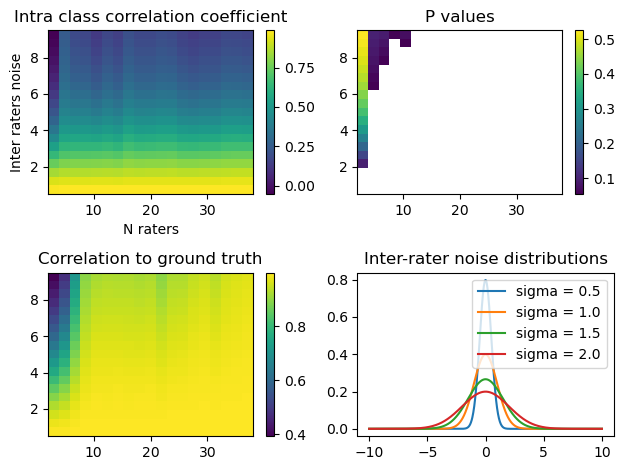

In [93]:
# Plot the results of the simulation:
fig, axs = plt.subplots(2, 2)
print(icc_results.shape)
img1 = axs[0, 0].imshow(icc_results, extent=[initial_raters[0], initial_raters[-1], inter_rater_noise[0], inter_rater_noise[-1]], aspect="auto", origin='lower')
axs[0, 0].set_title("Intra class correlation coefficient")
axs[0, 0].set_xlabel("N raters")
axs[0, 0].set_ylabel("Inter raters noise")
plt.colorbar(img1)
img2 = axs[0, 1].imshow(np.where(pvals < 0.05, np.nan, pvals), extent=[initial_raters[0], initial_raters[-1], inter_rater_noise[0], inter_rater_noise[-1]], aspect="auto", origin='lower')
axs[0, 1].set_title("P values")
plt.colorbar(img2)
img3 = axs[1, 0].imshow(corr_res, extent=[initial_raters[0], initial_raters[-1], inter_rater_noise[0], inter_rater_noise[-1]], aspect="auto", origin='lower')
axs[1, 0].set_title("Correlation to ground truth")
plt.colorbar(img3)
x = np.linspace(-10, 10, 1000)
axs[1, 1].plot(x, norm.pdf(x, 0, inter_rater_noise[0]), label=f'sigma = {inter_rater_noise[0]}')
axs[1, 1].plot(x, norm.pdf(x, 0, inter_rater_noise[1]), label=f'sigma = {inter_rater_noise[1]}')
axs[1, 1].plot(x, norm.pdf(x, 0, inter_rater_noise[2]), label=f'sigma = {inter_rater_noise[2]}')
axs[1, 1].plot(x, norm.pdf(x, 0, inter_rater_noise[3]), label=f'sigma = {inter_rater_noise[3]}')
axs[1, 1].legend()
axs[1, 1].set_title("Inter-rater noise distributions")
plt.tight_layout()